In [1]:
import xarray as xr
import cartopy.crs as ccrs

import math
import numpy as np

import matplotlib.pyplot as plt

import torch

In [237]:
cp_model_rotated_pole = ccrs.RotatedPole(
    pole_longitude=177.5,
    pole_latitude=37.5
)
platecarree = ccrs.PlateCarree()


class SelectDomain:

    # Domain centres in standard latitude and longitude
    DOMAIN_CENTRES_LON_LAT = {
        "london": (-0.118092, 51.509865),
        "birmingham": (-1.898575, 52.489471),
    }

    # Domain centres in rotated pole latitude and longitude
    DOMAIN_CENTRES_RP_LONG_LAT = {
        domain_name: cp_model_rotated_pole.transform_point(
            *lon_lat, src_crs=platecarree
        )
        for domain_name, lon_lat in DOMAIN_CENTRES_LON_LAT.items()
    }

    def __init__(self, subdomain, size=64) -> None:
        self.subdomain = subdomain
        self.size = size

    def run(self, ds):

        # Find the grid square in the dataset nearest to the centre
        # Assumes dataset is in rotated pole coordinates
        centre_rp_lon_lat = self.DOMAIN_CENTRES_RP_LONG_LAT[self.subdomain]
        centre_ds = ds.sel(
            grid_longitude=360.0 + centre_rp_lon_lat[0],
            grid_latitude=centre_rp_lon_lat[1],
            method="nearest",
        )

        # Find the INDEX of the central square in the grid latitude and longitude coordinates
        centre_long_idx = np.where(
            ds.grid_longitude.values == centre_ds.grid_longitude.values
        )[0].item()
        centre_lat_idx = np.where(
            ds.grid_latitude.values == centre_ds.grid_latitude.values
        )[0].item()

        # Set how many grid squares to go up, down, left and right from the centre box
        # in order to get a box the is self.size by self.size
        radius = self.size - 1
        left_length = math.floor(radius / 2.0)
        right_length = math.ceil(radius / 2.0)
        down_length = math.floor(radius / 2.0)
        up_length = math.ceil(radius / 2.0)

        # Select only the bits of the dataset that lie in the box defined
        ds = ds.sel(
            grid_longitude=slice(
                ds.grid_longitude[centre_long_idx - left_length].values,
                ds.grid_longitude[centre_long_idx + right_length].values,
            ),
            grid_latitude=slice(
                ds.grid_latitude[centre_lat_idx - down_length].values,
                ds.grid_latitude[centre_lat_idx + up_length].values,
            ),
        )

        return ds

<xarray.Dataset>
Dimensions:                     (ensemble_member: 1, time: 720,
                                 grid_latitude: 606, grid_longitude: 484,
                                 bnds: 2)
Coordinates:
  * ensemble_member             (ensemble_member) int32 1
  * time                        (time) object 1980-12-01 00:30:00 ... 1980-12...
  * grid_latitude               (grid_latitude) float64 -4.683 -4.647 ... 8.063
  * grid_longitude              (grid_longitude) float64 353.9 354.0 ... 364.3
    ensemble_member_id          (ensemble_member) |S27 ...
    latitude                    (grid_latitude, grid_longitude) float64 ...
    longitude                   (grid_latitude, grid_longitude) float64 ...
    month_number                (time) int32 ...
    year                        (time) int32 ...
    yyyymmddhh                  (time) |S64 ...
Dimensions without coordinates: bnds
Data variables:
    pr                          (ensemble_member, time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  int32 ...
    time_bnds                   (time, bnds) object ...
    grid_latitude_bnds          (grid_latitude, bnds) float64 ...
    grid_longitude_bnds         (grid_longitude, bnds) float64 ...
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-09-11T20:29:43
    domain:          uk
    frequency:       1hr
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

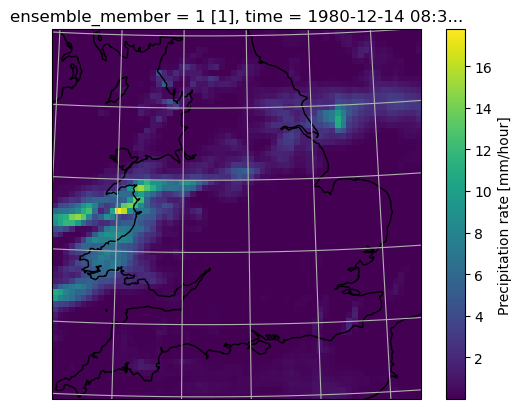

In [238]:
ds = xr.open_dataset("pr_rcp85_land-cpm_uk_2.2km_01_1hr_19801201-19801230.nc")
display(ds)

ds = ds.coarsen(grid_latitude=4, grid_longitude=4, boundary="trim").mean()
ds = SelectDomain("birmingham", size=64).run(ds)

cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
ax = plt.axes(projection=cp_model_rotated_pole)
ds.isel(time=320).pr.plot(ax = ax, x = 'longitude', y = 'latitude', transform = ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()
plt.show()

In [ ]:
MONTHS_IN_SEASON = 3
DAYS_IN_MONTH = 30
HOURS_IN_DAY = 24
HOURS_IN_SEASON = MONTHS_IN_SEASON * DAYS_IN_MONTH * HOURS_IN_DAY

train_ranges = 

<xarray.DataArray 'time' (time: 720)>
array([cftime.Datetime360Day(2080, 2, 1, 0, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2080, 2, 1, 1, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2080, 2, 1, 2, 30, 0, 0, has_year_zero=True), ...,
       cftime.Datetime360Day(2080, 2, 30, 21, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2080, 2, 30, 22, 30, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2080, 2, 30, 23, 30, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time          (time) object 2080-02-01 00:30:00 ... 2080-02-30 23:30:00
    month_number  (time) int32 ...
    year          (time) int32 ...
    yyyymmddhh    (time) |S64 ...
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time

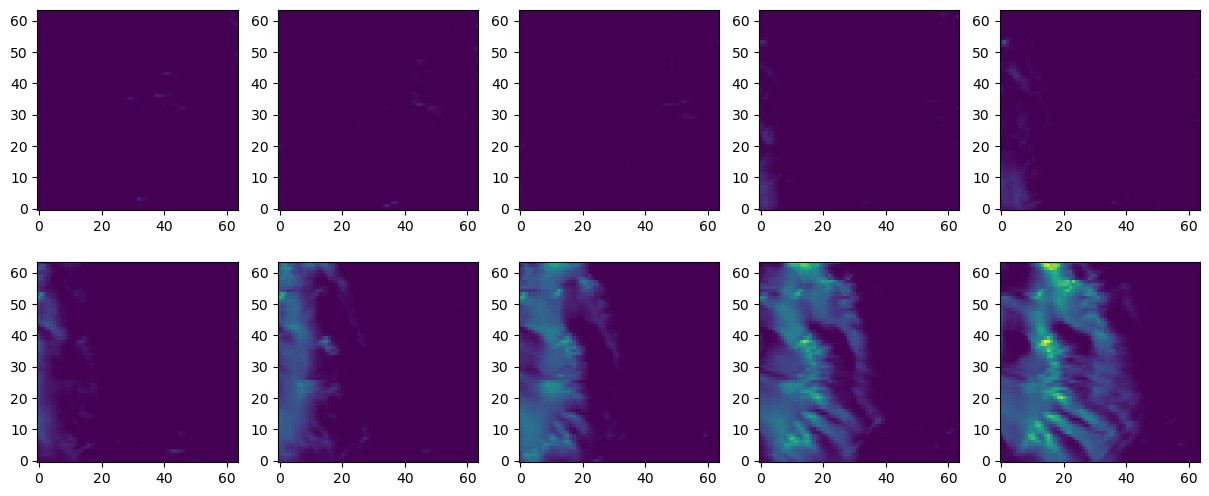

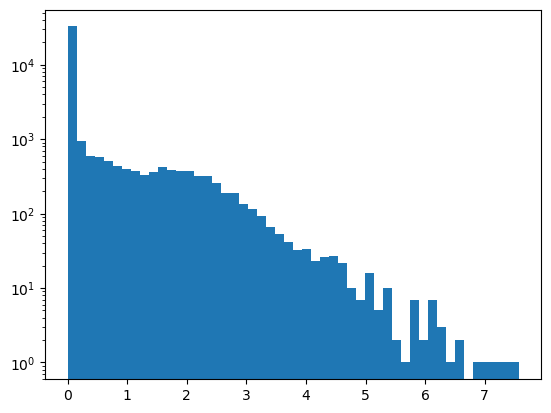

min: 0.0, max: 7.567968368530273, mean: 0.29529401659965515


In [6]:
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_19801201-19801230.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20660501-20660530.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801101-20801130.nc")

ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800201-20800230.nc")
display(ds.time)
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800301-20800330.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800401-20800430.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800501-20800530.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800601-20800630.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800701-20800730.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800801-20800830.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20800901-20800930.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801001-20801030.nc")
# ds = xr.open_dataset("pr_rcp85/pr_rcp85_land-cpm_birmingham-64_2.2km-coarsened-4x-2.2km-coarsened-4x_01_1hr_20801101-20801130.nc")

index = 710
pr = ds.isel(time = slice(index, index + 10)).pr.values[0]

fig, axs = plt.subplots(2, 5, figsize = (15, 6))
for i in range(10):
    ax = axs.flat[i]
    frame = pr[i]
    ax.imshow(frame, origin = "lower", vmin = pr.min(), vmax = pr.max())
plt.show()

plt.hist(pr.flatten(), bins = 50)
plt.yscale("log")
plt.show()

print(f"min: {pr.min()}, max: {pr.max()}, mean: {pr.mean()}")

In [5]:
data = xr.open_mfdataset("pr_rcp85/*.nc")

chunk_size = 10

num_chunks = data.dims['time'] // chunk_size

chunk_indices = np.arange(num_chunks)
np.random.shuffle(chunk_indices)

train_indices = chunk_indices[:int(0.8 * num_chunks)]
test_indices = chunk_indices[int(0.8 * num_chunks):int(0.9 * num_chunks)]
val_indices = chunk_indices[int(0.9 * num_chunks):]

train_indices.sort()
test_indices.sort()
val_indices.sort()

print(train_indices)

for split, indices in [('train', train_indices), ('test', test_indices), ('val', val_indices)]:
    chunks = []

    for index in indices:
        start = index * chunk_size
        end = (index + 1) * chunk_size
        chunk = data.isel(time = slice(start, end))
        chunks.append(chunk)
        
    split_data = xr.concat(chunks, dim = 'time')

[  0   1   4   5   6   7   9  10  11  12  13  14  15  16  17  19  20  21
  22  23  24  25  26  28  29  31  33  34  35  37  38  39  40  42  43  45
  46  48  49  50  51  52  53  54  55  56  57  58  59  60  61  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  79  80  81  82  83  84
  86  87  88  89  91  92  93  95  96  97  98 100 101 102 103 104 105 106
 107 109 110 112 113 116 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 139 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 158 159 160 161 162 163 164 165 166 168 169
 170 171 172 176 178 180 181 183 185 186 187 188 189 190 191 193 194 196
 197 198 200 201 202 203 204 205 206 208 209 210 212 213 214 215 216 217
 219 220 221 222 223 224 225 227 228 229 230 231 233 234 235 236 237 238
 239 240 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 267 268 269 270 271 272 273 274 275 276
 277 279 280 281 283 284 285 286 288 289 290 291 29


Example 0:
min: 0.0, max: 18.57134437561035
mean: 0.22759023308753967
torch.Size([10, 64, 64])


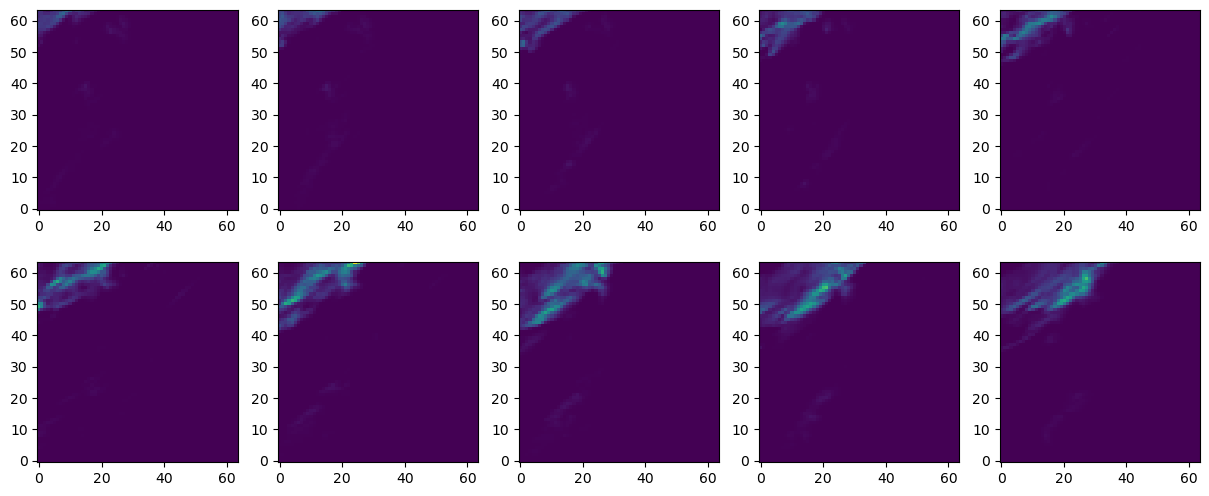

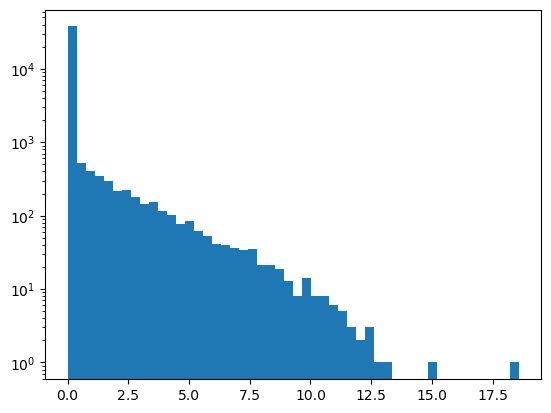


Example 1:
min: 0.0, max: 1.2101480024284683e-05
mean: 2.1214809464709106e-07
torch.Size([10, 64, 64])


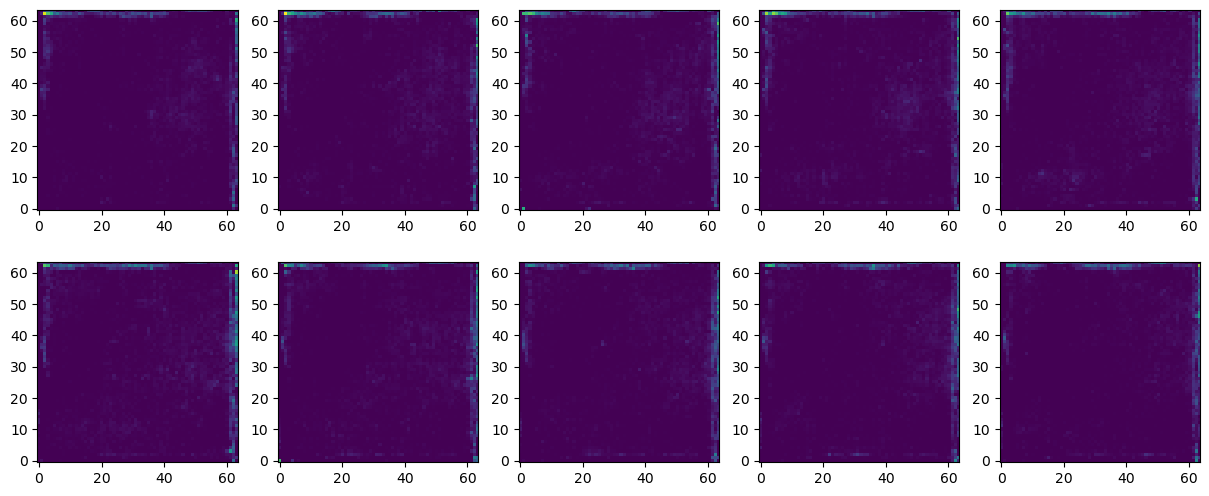

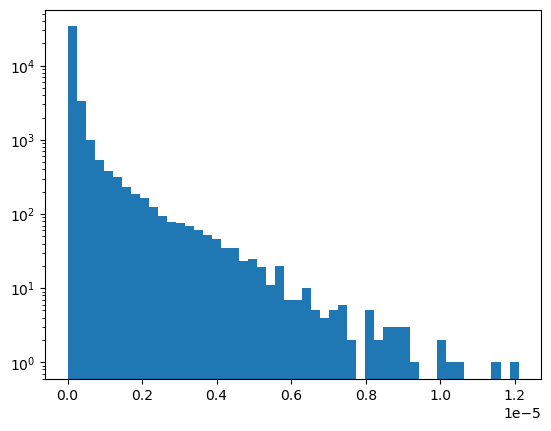

In [88]:
# ds = torch.load("results/results_2r/70.pt", map_location=torch.device('cpu'))
# ds = torch.load("results/results_2r_l2/78.pt", map_location=torch.device('cpu'))
# ds = torch.load("78.pt", map_location=torch.device('cpu'))
ds = torch.load("samples.pt", map_location=torch.device('cpu'))

# all_values = ds.flatten()
# plt.hist(np.log10(all_values + 1e-8), bins = 300)
# plt.show()

for i in range(2):
    ex = ds[i][0]
    print(f"\nExample {i}:")
    print(f"min: {ex.min()}, max: {ex.max()}\nmean: {ex.mean()}")
    print(ex.shape)
    fig, axs = plt.subplots(2, 5, figsize = (15, 6))
    for j in range(10):
        ax = axs.flat[j]
        frame = ex[j]
        ax.imshow(frame, origin = "lower", vmin = ex.min(), vmax = ex.max())
    plt.show()

    plt.hist(ex.flatten(), bins = 50)
    plt.yscale("log")
    plt.show()